# `tundraden` basic example

Let's first generate some random correlated predictors. They are generated using a multivariate normal distribution, so by chosing the covariance matrix we can chose how correlated the regressors are. Here I generate 3 regressors, the 2 first ones being strongly correlated to each other and the third one being uncorrelated to the 2 previous ones:

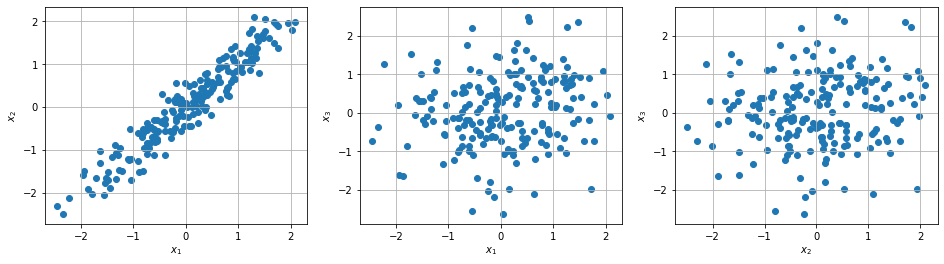

In [30]:
import tundraden
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

n_samples = 200
covariance_matrix = np.array([
    [1.0, 1.0, 0.0],
    [1.0, 1.1, 0.0],
    [0.0, 0.0, 1.0],
])
X = tundraden.generate_correlated_data(covariance_matrix, n_samples)

plt.figure(figsize=(16,4))
k = 1
for i in range(X.shape[1]):
    for j in range(i+1, X.shape[1]):  
        plt.subplot(1,3,k)
        plt.scatter(X[:,i], X[:,j])
        plt.xlabel('$x_%i$'%(i+1))
        plt.ylabel('$x_%i$'%(j+1))
        plt.grid()
        k += 1
plt.show()

Now I generate the dependent variable using arbitrary weights for each regressor and extra noise:

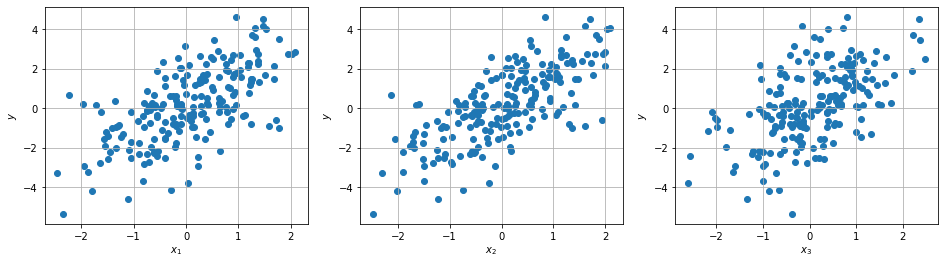

In [31]:
weights = np.array([-1, 2, 1])
sigma = 1
Y = tundraden.generate_target(X, weights, sigma)

plt.figure(figsize=(16,4))
for i in range(3):
    plt.subplot(1,3,i+1)
    plt.scatter(X[:,i], Y)
    plt.xlabel('$x_%i$'%(i+1))
    plt.ylabel('$y$')
    plt.grid()
plt.show()

Let's try a simple linear regression:

In [32]:
model = LinearRegression()
model.fit(X, Y)
model.coef_

array([-0.99011405,  2.0972949 ,  0.92248078])

As we can see the weights are poorly estimated. Let's check the intercept as a matter of principle:

In [33]:
model.intercept_

0.036476420644211416

A way of measuring the multicollinearity or the data is to calculate the coefficient of multiple determination $R^2_i$ and/or the variance inflation factor $VIF_i$ for each predictor $X_i$:

In [34]:
r2, vif = tundraden.measure_multicollinearity(X)
r2

array([0.90854744, 0.9081534 , 0.02597143])

In [35]:
vif

array([10.93463124, 10.88771874,  1.02666393])

As we can see both $R^2_i$ and $VIF_i$ are high for the first two predictors.